# Forecasting temperature with SARIMA


## Introduction

> Weather forecasting is a difficult but important task. All predictions have a degree of uncertainty, but the chaotic character of our atmosphere causes weather forecasting to become especially challenging. As you might have experienced yourself, day-to-day weather prediction becomes unreliable more than a week into the future. 

The aim for this project is to find an appropriate model able to forecast monthly mean air temperature in Stockholm. 



https://irjabs.com/files_site/paperlist/r_449_121110152548.pdf

http://www.statistics.du.se/essays/D09_Xier_Li.pdf

http://www.statistics.du.se/essays/D08D_XiangJunquan.pdf

In [184]:
library(plotly);
library(ggplot2);
library(ggfortify);
library(repr);
library(tidyr);
library(tsibble);
library(TSstudio);
library(zoo);
library(dplyr);
library(tseries)
library(forecast);

library(ggridges)
library(viridis)
library(hrbrthemes)
library(heatmaply)
library(gridExtra)

Sys.setlocale(locale = "English");
windowsFonts(Times=windowsFont("Times New Roman"));

options(repr.plot.width=10, repr.plot.height=6)

# Center position of plots
IRdisplay::display_html('<style>.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}</style>')

th <- theme(text=element_text(size = 20, face = "bold",  family="Times"),
        plot.title = element_text(size = 25, face = "bold",  family="Times", hjust = 0.5),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        panel.background = element_rect(fill = "white"),
        panel.grid = element_line(size = 0.25, linetype = 'solid',
                                colour = "grey80"))

[1] "LC_COLLATE=English_United States.1252;LC_CTYPE=English_United States.1252;LC_MONETARY=English_United States.1252;LC_NUMERIC=C;LC_TIME=English_United States.1252"

https://bolin.su.se/data/stockholm-historical-monthly-temperature-3?n=stockholm-historical-temps-monthly-3

## Models

The autoregressive moving-average (ARMA) process is an fundamental parametric family of stationary time series. If selected time series (i) does not exhibit evidence against stationarity and (ii) rapidly decreasing autocovariance function, an ARMA could potentially be fitted to the mean-corrected data. Otherwise, considering autoregressive integrated moving-average (ARIMA) can prove to be wise. For a time series {$X_t$}, SARIMA is defined as

$$
\phi(B)(1-B)^d X_t = \theta(B)Z_t, \quad {Z_t} \sim WN(0, \sigma^2)
$$
where $\phi(z)$ and $\theta(z)$ are a

If the time series has an apparent seasonal component, seasonal ARIMA (SARIMA) becomes a valid option. 

Finding an appropriate model for non-stationary time series require the use of autoregressive integrated moving-average (ARIMA). 

## Data source
The data consist out of 36 years of monthly mean air temperatures. 

In [185]:
train_df <- read.csv("dataset/train_stockholm_monthly_mean_temperature.csv", sep=';')
test_df <- read.csv("dataset/test_stockholm_monthly_mean_temperature.csv", sep=';')
df <- rbind(train_df, test_df)
head(df)

,year,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1980,-4.7,-6.2,-3.1,4.8,7.8,15.6,16.8,14.6,12.8,5.7,0.0,-0.8
2,1981,-4.0,-2.7,-2.2,3.9,10.8,12.6,16.4,14.6,11.7,6.5,1.1,-5.7
3,1982,-7.2,-4.0,1.1,4.1,9.4,12.5,17.4,17.0,12.3,7.6,4.5,0.3
4,1983,0.7,-3.8,-0.1,4.0,10.2,14.0,18.0,17.8,12.4,7.5,1.2,-1.1
5,1984,-3.0,-1.7,-2.0,5.3,10.9,13.3,15.3,16.4,10.6,8.9,4.3,0.8
6,1985,-9.0,-11.6,-1.7,1.6,9.0,13.6,15.9,15.4,10.3,8.0,0.3,-4.3


In [186]:
train <- ts(as.vector(t(as.matrix(train_df[,-1]))), start=c(min(train_df$year), 1), 
            end=c(max(train_df$year), 12), frequency =12)

df_ts <- ts(as.vector(t(as.matrix(df[,-1]))), start=c(1980, 1), 
            end=c(2020, 12), frequency =12)

# Reshaped version for visualization
train_reshape <- data.frame(date=as.Date(as.yearmon(time(train))), temp=as.matrix(train))
train_reshape$month <- format(train_reshape$date, "%b")
train_reshape$year <- format(train_reshape$date, "%Y")

head(train_reshape)

,date,temp,month,year
,<date>,<dbl>,<chr>,<chr>
1,1980-01-01,-4.7,Jan,1980
2,1980-02-01,-6.2,Feb,1980
3,1980-03-01,-3.1,Mar,1980
4,1980-04-01,4.8,Apr,1980
5,1980-05-01,7.8,May,1980
6,1980-06-01,15.6,Jun,1980


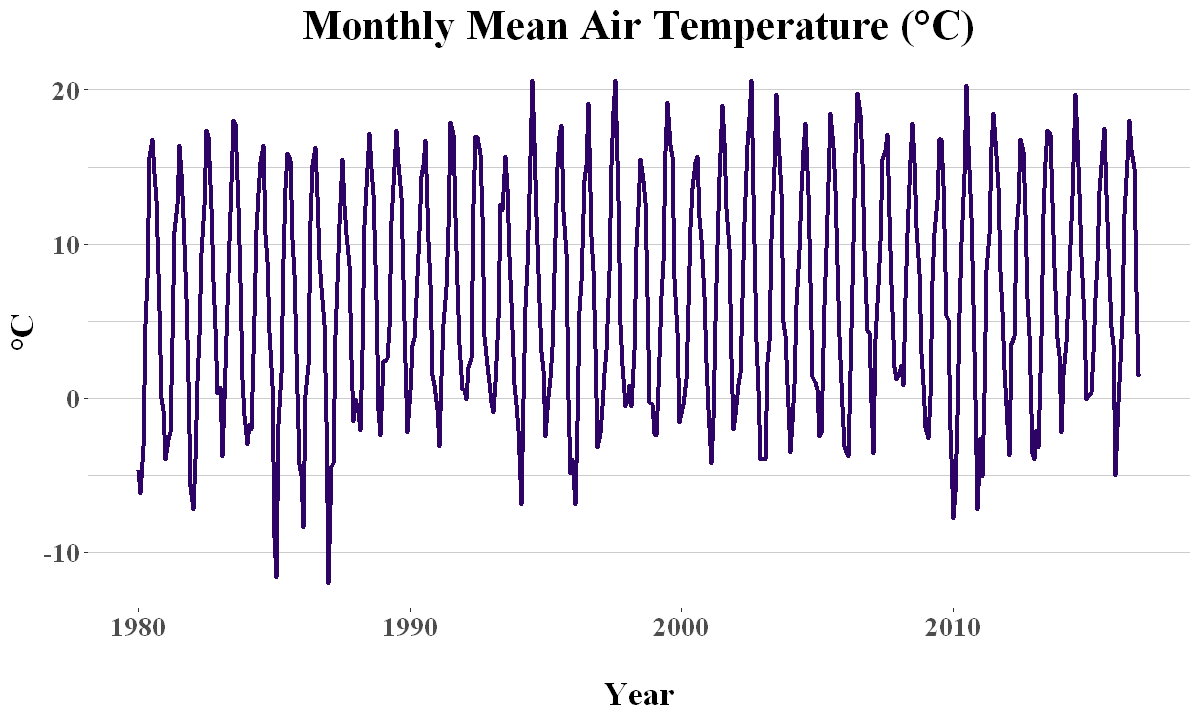

In [187]:
ggplot(data=train_reshape, aes(x=date, y=temp, group=1))+
    ggtitle("Monthly Mean Air Temperature (°C)")+
    geom_line(color="#2d0365", size=1.2)+
    xlab("\nYear") + ylab("°C") +
    th + theme(legend.position="none")

> Ridgeline plot. Potential outliers in January and February. 

Picking joint bandwidth of 0.787



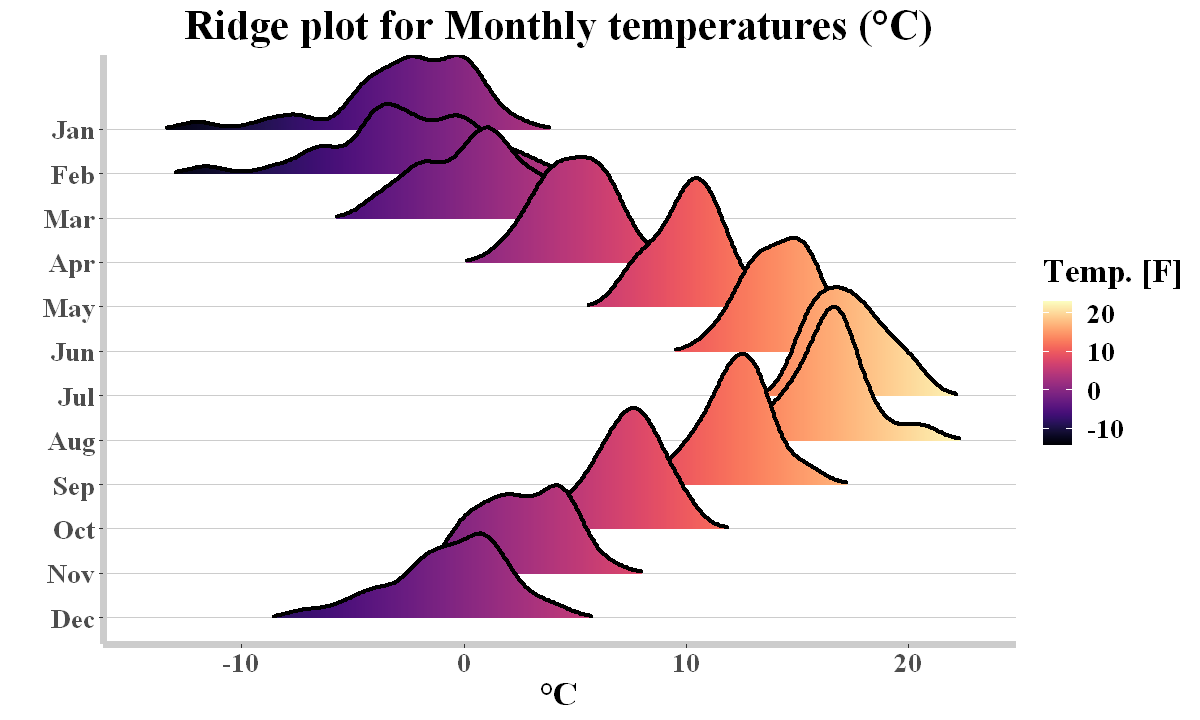

In [188]:
ggplot(train_reshape, aes(x = temp, y = factor(month, levels = month.abb), fill = ..x..))+
    geom_density_ridges_gradient(scale = 3, rel_min_height = 0.01, lwd=1.2) +
    scale_fill_viridis(name = "Temp. [F]", option = "A") +
    labs(title = 'Ridge plot for Monthly temperatures (°C)') +
    scale_y_discrete(limits=rev) +
    xlab("°C") + ylab("") +
    th + theme(axis.line = element_line(size = 2, colour = "grey80"))

Outliers are better visualised through a boxplot. From both the ridge plot and boxplot, it appears is if the variance is not consistent over months.

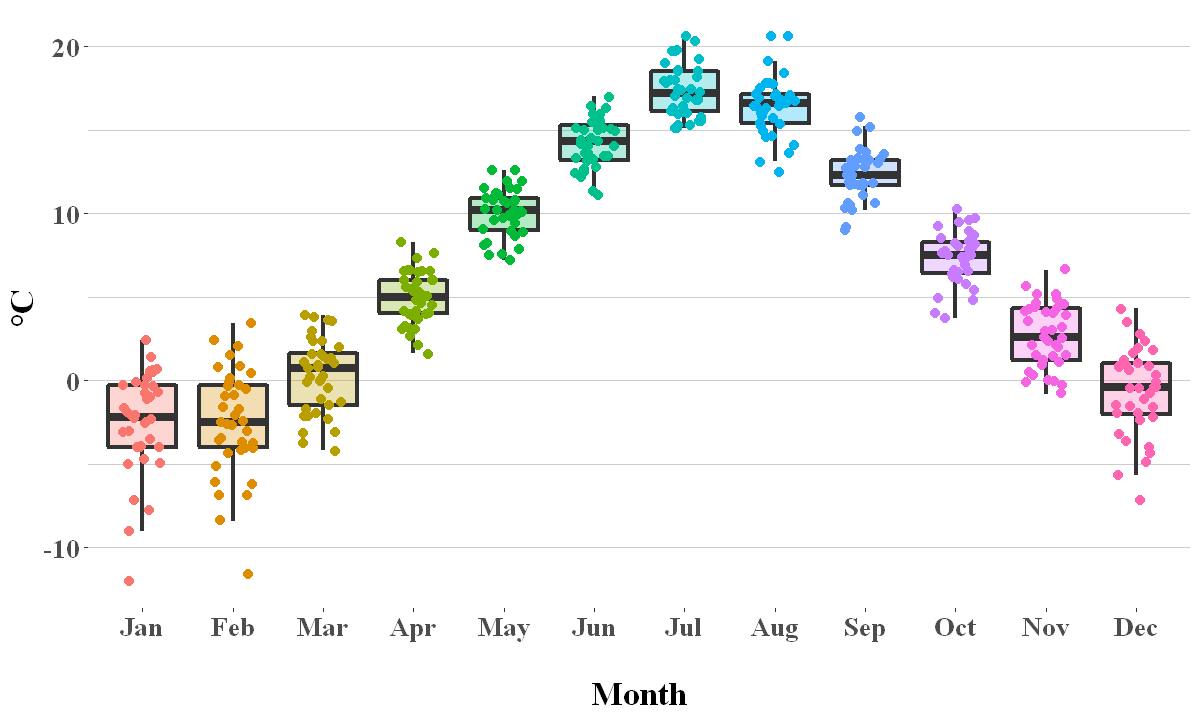

In [189]:
ggplot(train_reshape, aes(x = factor(month, levels = month.abb), y = temp, fill=factor(month, levels = month.abb)))+
    geom_boxplot(outlier.alpha = 0, alpha=0.3, lwd=1.2) +
    geom_jitter(size=2.4, position=position_jitter(0.23), aes(colour=factor(month, levels = month.abb)))+ 
    xlab("\nMonth") + ylab("°C") +
    th + theme(legend.position="none")

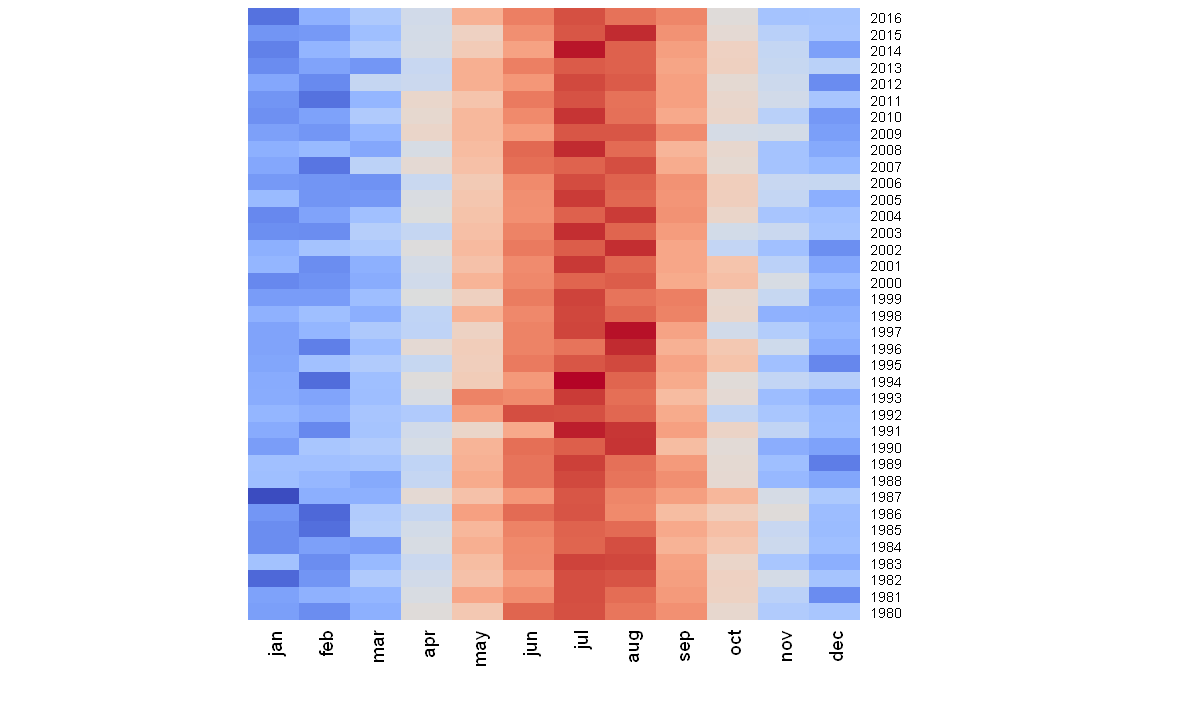

In [190]:
dt <- as.matrix(train_df[,-1])

heatmap(dt, Colv =NA, Rowv =NA, col=cool_warm(256), labRow=as.matrix(train_df["year"]))

Our seasonal component is clear at this point and is once again confirmed through the ACF plot. No clear trend seem to be apparent.

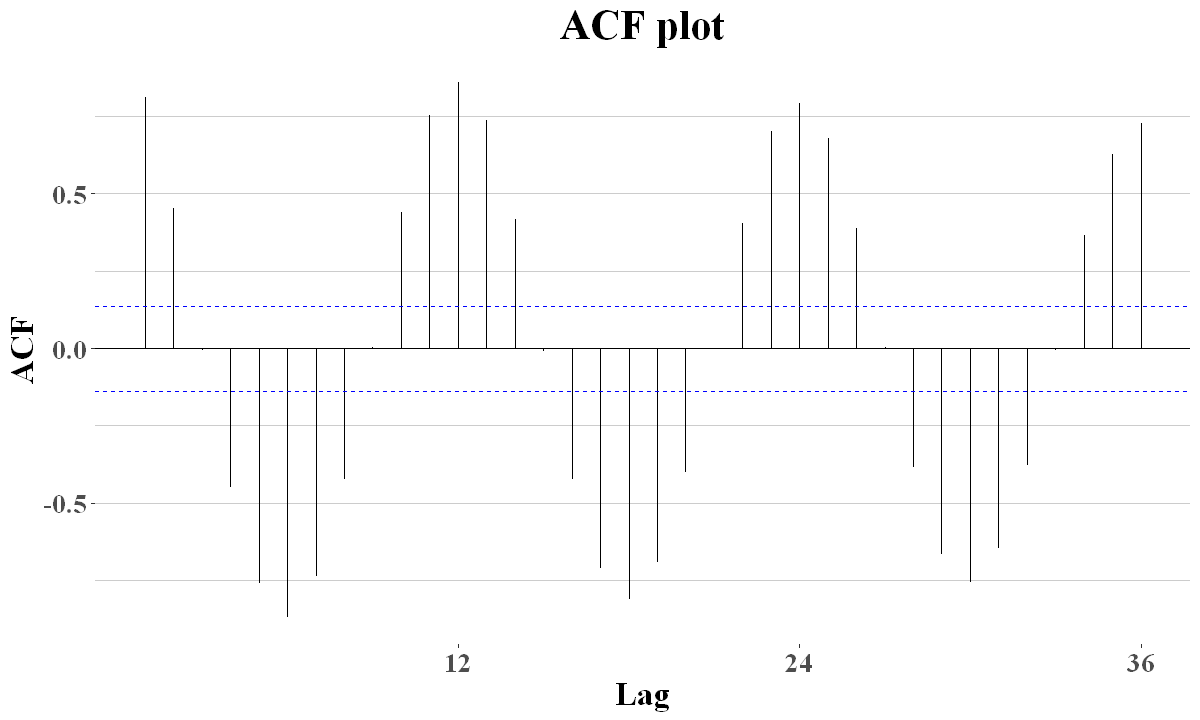

In [205]:
ggAcf(train, lag.max = 36) +
    labs(title = 'ACF plot')+
    th

With monthly data, our dominating period is obviosly 12. The periodogram can be useful to identify other periods or if one is unsure of dominating period. Following periodogram is calculated using a fast Fourier transform and smooth through a series of modified Daniell smoothers.

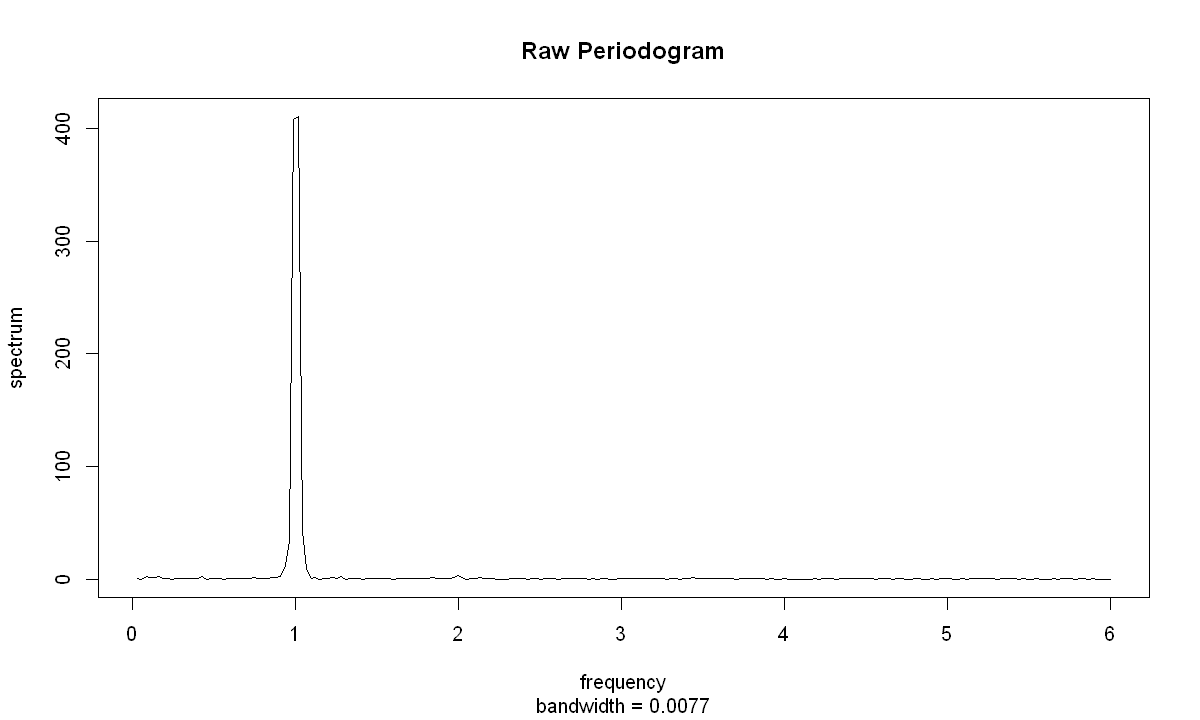

In [192]:
spec.pgram(train, log="no", main="Raw Periodogram")

Taking the seasonal difference result in following time series. No trend can be seen and one might feel tempted to fit our first model.

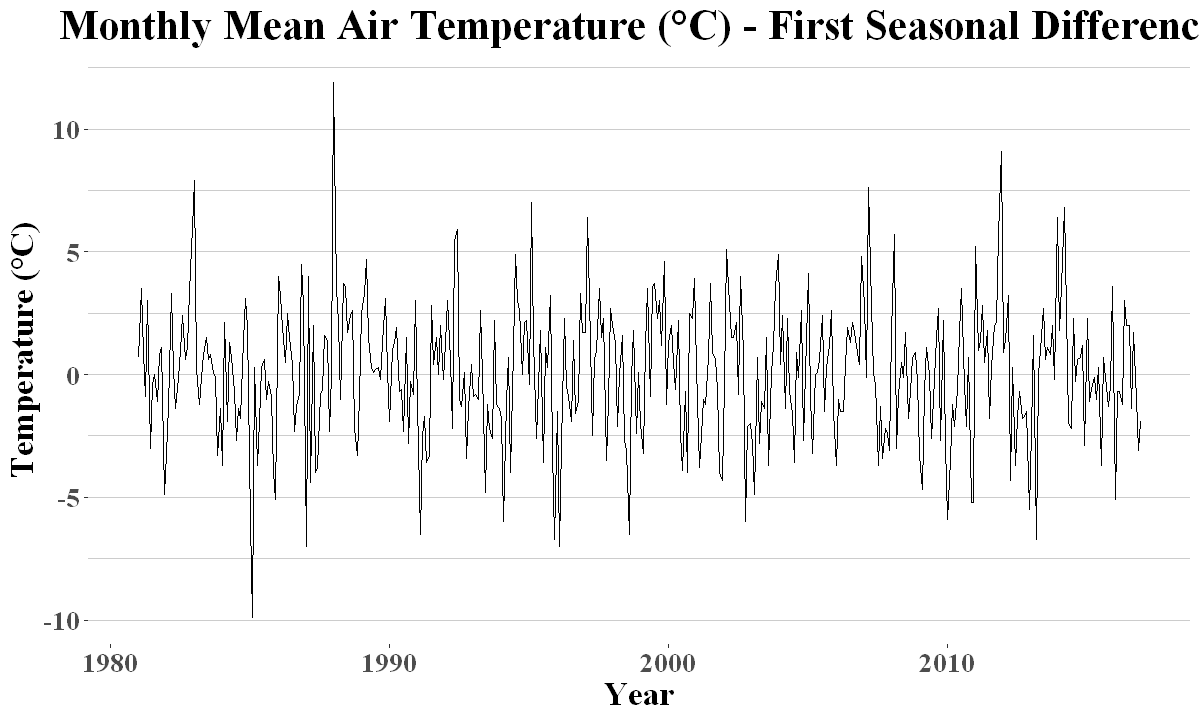

In [193]:
# Seasonal difference
train.diff = diff(train, lag=12)
autoplot(train.diff, xlab="Year", ylab="Temperature (°C)")+
    ggtitle("Monthly Mean Air Temperature (°C) - First Seasonal Difference")+ 
    th + 
    guides(colour = guide_legend(title.hjust = 20))

**Augmented Dicker-Fuller test**. 

Rejection of null hypotheisis, evidence of stationarity. It should be notet however most unit root tests does have a high type 1 error rate, that is incorrect rejection of a true null hypothesis.

In [194]:
adf.test(train.diff)

Warning message in adf.test(train.diff):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  train.diff
Dickey-Fuller = -6.5205, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary


**Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test**.
Check if time series is stationary around a deterministic trend. Presence of unit root is not the null hypothesis but rather the alternative.

In [202]:
kpss.test(train.diff)

Warning message in kpss.test(train.diff):
"p-value greater than printed p-value"



	KPSS Test for Level Stationarity

data:  train.diff
KPSS Level = 0.021325, Truncation lag parameter = 5, p-value = 0.1


A good way of visualising seasonal changes through time is a seasonal subseries plot. Looking at our data, months does not exhibit the same variance across all months. September seem to have quite low variance in relation to January or December. 

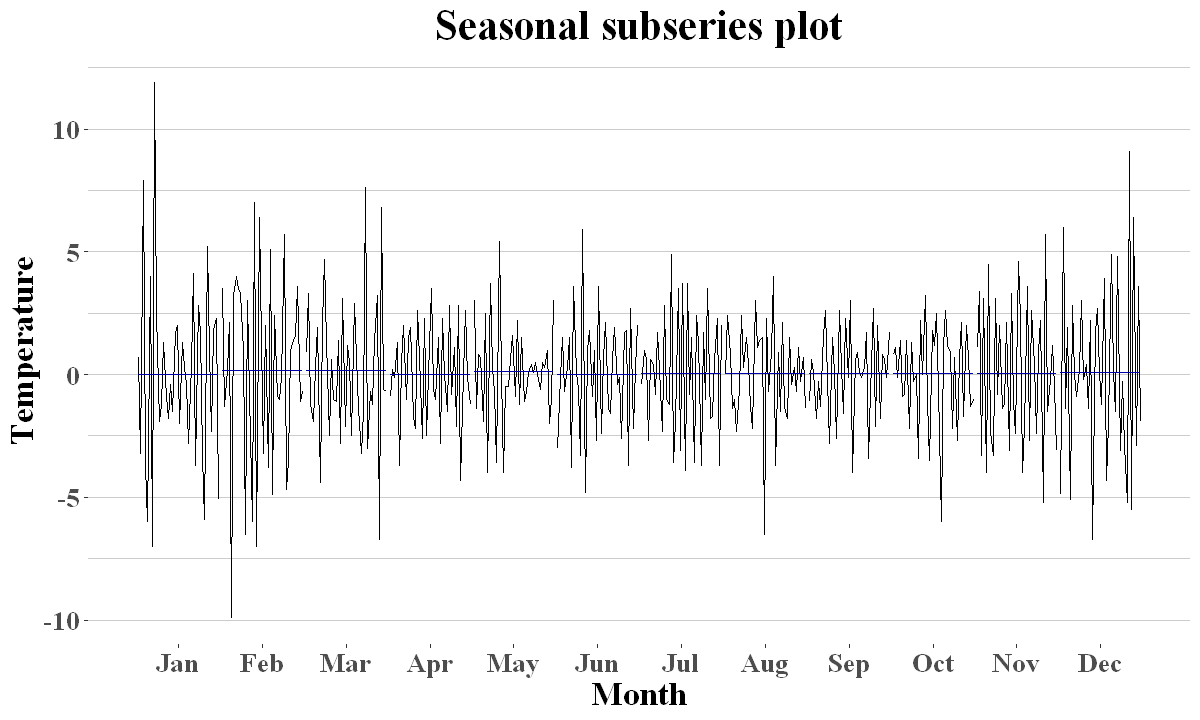

In [196]:
ggsubseriesplot(train.diff) +
    ylab("Temperature") +
    ggtitle("Seasonal subseries plot") +
    th

### What to do next?

Our data set has problematic characeristics which might not be captured by an ordinary ARIMA model. Our training period is long, with 40 years of observations. How old observations are still relevant in prediciting future temperature? Signs of strucutral breaks has been spotted and it might prove wise to use a shorter training period.

In [197]:
train <- ts(as.vector(t(as.matrix(train_df[,-1]))), start=c(2000, 1), 
            end=c(max(train_df$year), 12), frequency =12)

### Transformation
We could perhaps transform our data. We need to add a constant if we wish to use the log scale.

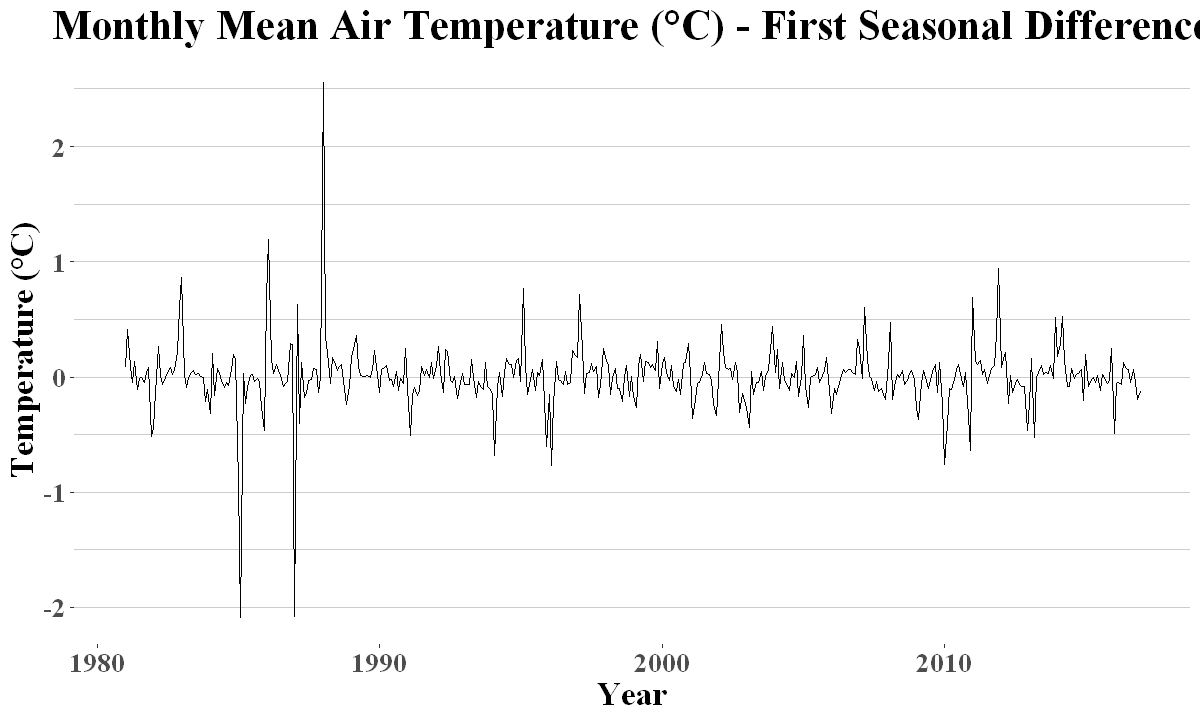

In [198]:
a = 1 - min(as.vector(t(as.matrix(train_df[,-1]))))

train_log <- ts(log(as.vector(t(as.matrix(train_df[,-1])))+a), start=c(min(train_df$year), 1), 
            end=c(max(train_df$year), 12), frequency =12)

autoplot(diff(train_log, lag=12), xlab="Year", ylab="Temperature (°C)")+
    ggtitle("Monthly Mean Air Temperature (°C) - First Seasonal Difference")+ 
    th + 
    guides(colour = guide_legend(title.hjust = 20))

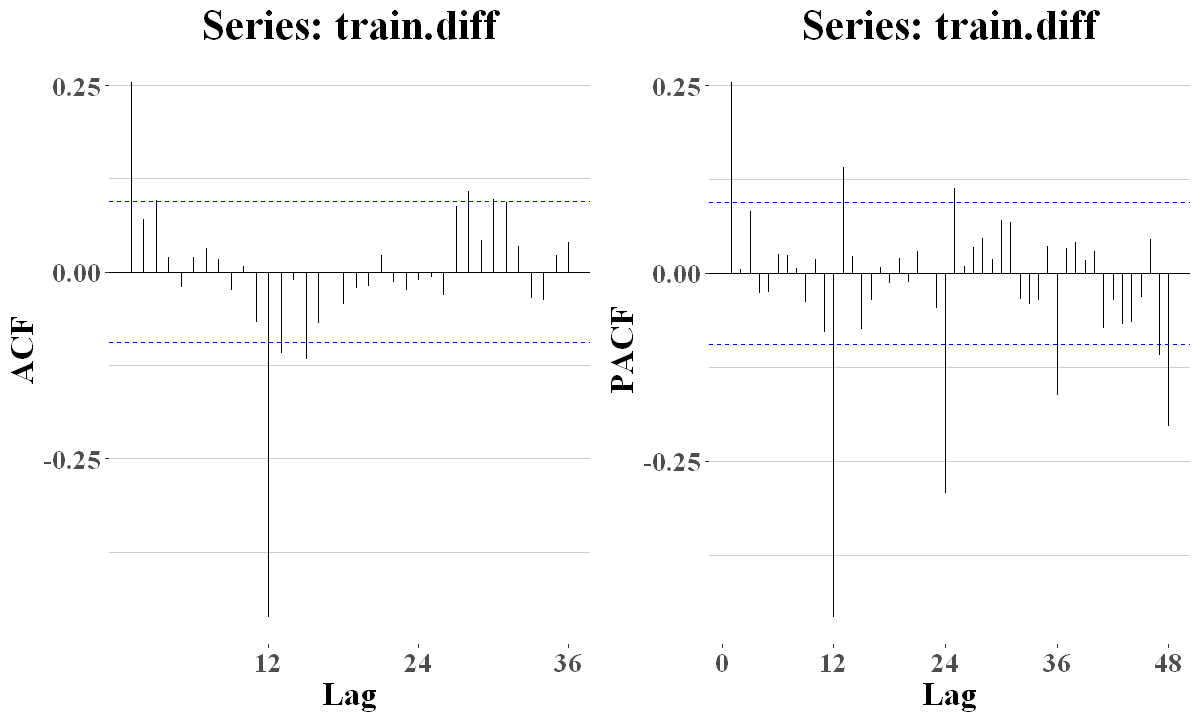

In [199]:
p1 = ggAcf(train.diff, lag.max = 36) +
    th

p2 = ggPacf(train.diff, lag.max = 48) +
    th

grid.arrange(p1, p2, ncol=2)

In [200]:
p <- q <- P <- Q <- 0:3
grid <- expand.grid(p=p, q=q, P=P, Q=Q)
grid$k <- rowSums(grid)
grid <- grid %>% filter(k<=4)

arima_search <- lapply(1:nrow(grid), function(i){
    mdl <- NULL
    mdl <- try(arima(train, order=c(grid$p[i], 0, grid$q[i]), 
                     seasonal=list(order=c(grid$P[i], 1, grid$Q[i]), period=12)))
    
    aic_scores <- data.frame(p = grid$p[i], d=0, q=grid$q[i], P=grid$P[i], D=1, Q=grid$Q[i], AIC = mdl$aic)
}) %>% bind_rows() %>% arrange(AIC)

head(arima_search)

Error in optim(init[mask], armafn, method = optim.method, hessian = TRUE,  : 
  non-finite finite-difference value [1]


ERROR: Error: $ operator is invalid for atomic vectors


# Autoarima

In [ ]:
mdl = auto.arima(train, allowdrift = FALSE)
print(mdl)
checkresiduals(mdl)

# Residual Check

In [ ]:
mdl <- arima(train, order = c(1, 0, 0), seasonal=list(order=c(1,1,2)))
checkresiduals(mdl)

In [ ]:
Box.test(mdl$residuals)

In [ ]:
qqnorm(mdl$residuals, pch=1, frame=FALSE)
qqline(mdl$residuals, col="steelblue", lwd=2)
shapiro.test(mdl$residuals)

In [ ]:
cpgram(mdl$residuals, main="Cumulative Periodogram of the residuals")

# Forecasting

In [ ]:
# Forecasting

mdl <- arima(train, order = c(1, 0, 0), seasonal=list(order=c(1,1,0)))
pred <- predict(mdl, n.ahead=48)
ts.plot(df_ts, xlim= c(2012, 2021))

points(pred$pred, type="l", col="blue", lty=2)
lines(pred$pred+2*pred$se, col="red", lty=2)
lines(pred$pred-2*pred$se, col="red", lty=2)

In [ ]:
mdl

# Further improvements

A GARCH model would capture the conditional variance and might give better result than ARIMA could.